# Least Square Estimation of AR Models and Whitening - Part I
---

### Estimation of a AR process of order 1 using the entire dataset

AR parameters
  Original |  Estimated
-------------------------
   0.04127 |    0.02259


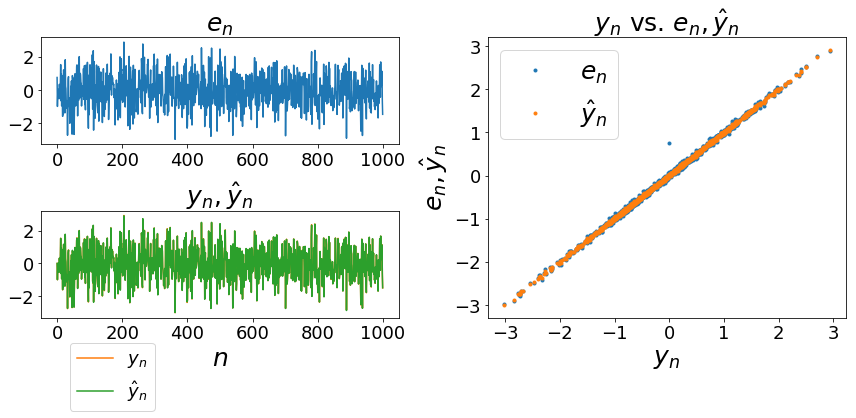

In [8]:
_ = genEstARProc(p=1, N=1000)

### Running estimate of a AR process of order 1

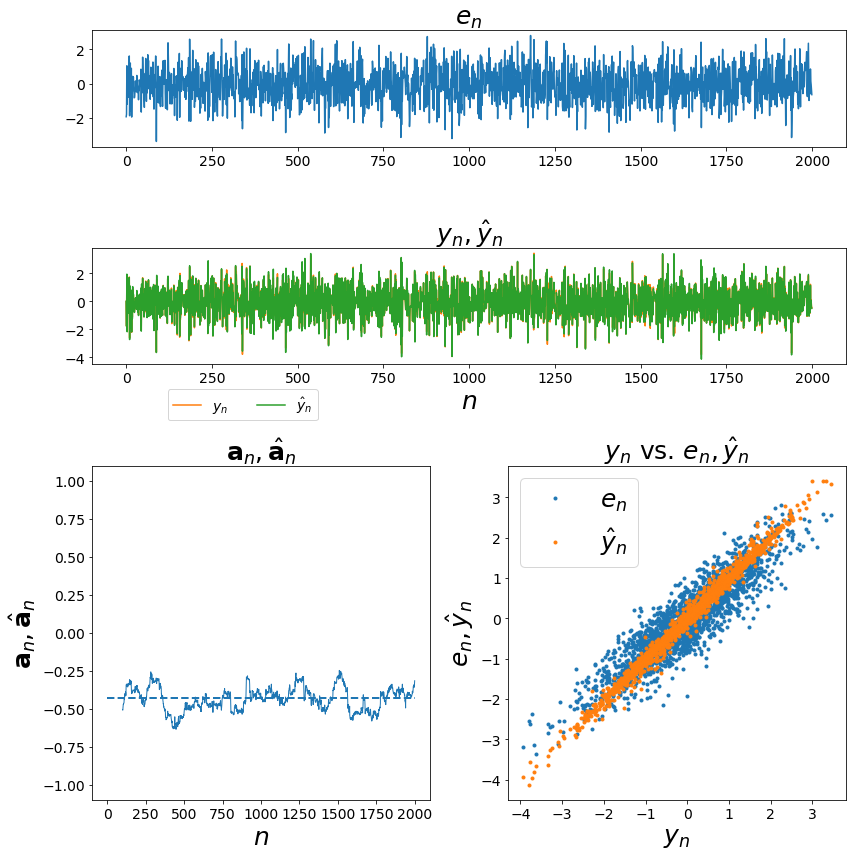

In [10]:
param, fig = genRunEstARProc(p=1, N=2000, L=100, dL=1, eparam=(0, 1.0))
fig.savefig("../figs/ar1.png", format="png", dpi=300)

## Running estimate of a order 'p' process

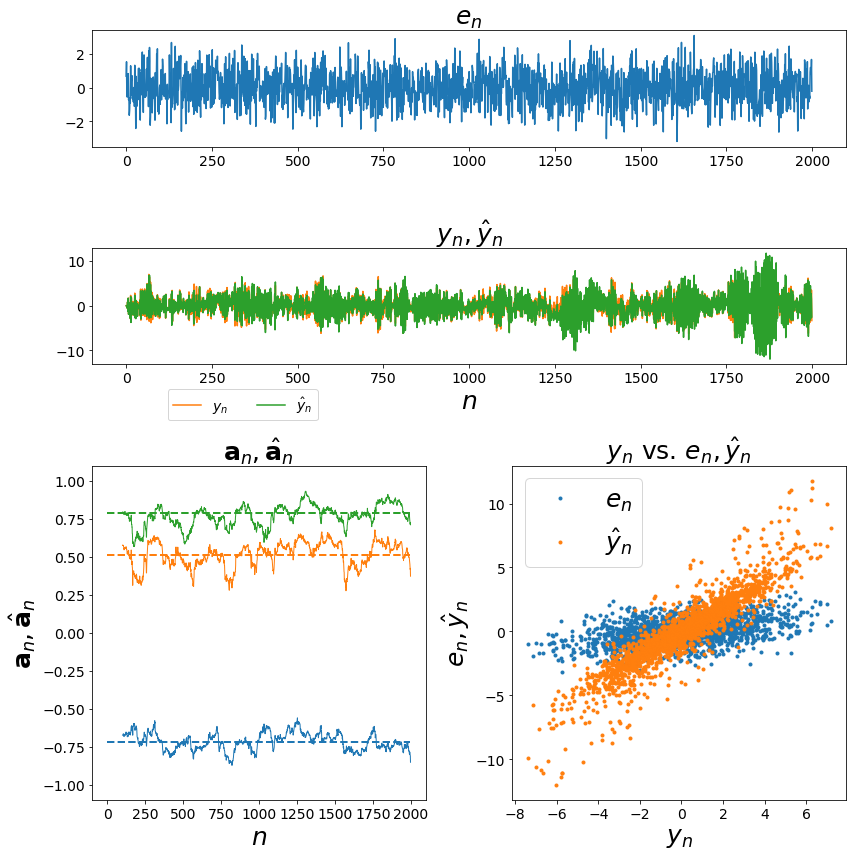

In [11]:
param, fig = genRunEstARProc(p=3, N=2000, L=100, dL=1, eparam=(0, 1.0));
fig.savefig("../figs/ar3.png", format="png", dpi=300)

In [2]:
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Stationary AR process implementation
def genARProcess(a, e):
    N = len(e)
    p = len(a)
    # Generate the filtered signal
    y = np.zeros(N)
    for i in xrange(p, N):
        y[i] = e[i]
        for k in xrange(p):
            y[i] += a[k] * y[i - k - 1]
    return y

# Output of the AR process from time-varying parameters.
def genARProcessTimeVarParam(an, a, e):
    N = len(e)
    p = len(a)
    # Generate the filtered signal
    y = np.zeros(N)
    j = 0
    for i in xrange(p, N):
        y[i] = e[i]
        if (i > an[j]):
            j += 1
        for k in xrange(p):
            y[i] += a[k, j] * y[i - k - 1]
    return y

# Estimation of AR parameters.
def estARParam(p, y):
    N = len(y)
    ymat = np.zeros((N - p, p))
    yb = np.zeros((N - p - 1, 1))
    for c in xrange(p, 0, -1):
        ymat[:, p-c] = y[p-c:-c]
    yb = y[p:]
    return np.matmul(np.linalg.pinv(ymat), yb)[::-1]

# Running estimate of AR parameters.
def estRunARParam(p, y, L=None, dL=1):
    N = len(y)
    # Assign default window size
    if L is None:
        L = N - p
    arn = []
    arhat = []
    for _n in xrange(L+p-1, N, dL):
        arn.append(_n)
        arhat.append(estARParam(p, y[_n-L-p+1:_n+1]))
    # Always add a estimate using the last data.
    if (arn[-1] < N-1):
        arn.append(N-1)
        arhat.append(estARParam(p, y[N-L-p:N]))
    return np.array(arn), np.array(arhat).T

# Implementation of stationary whitening filter.
def whiten(y, ahat):
    N = len(y)
    p = len(ahat)
    w = np.zeros(N)
    for i in xrange(N):
        w[i] = y[i]
        for k in xrange(p):
            if i - k - 1 >= 0:
                w[i] += - ahat[k] * y[i - k - 1]
    return w

In [4]:
def genEstARProc(p, N=1000, eparam=(0, 1.0)):
    """
    """
    # AR parameters
    a = 1.8 * np.random.rand(p) - 0.9

    # Time series data
    n = np.arange(0, N)

    # Input white noise
    e = np.sqrt(eparam[1]) * np.random.randn(N) + eparam[0]

    # Generate AR time series.
    y = genARProcess(a, e)

    # Estimate autogressive model parameters
    ahat = estARParam(p, y)

    # Generate time series using estimated parameters
    yhat = genARProcess(ahat, e)
    
    # Plot results
    fig = plot_arfit(n, e, y, yhat)

    # Original and estimated parameters
    print "AR parameters"
    print "  Original |  Estimated"
    print "-------------------------"
    for i in xrange(len(a)):
        print "{0:10.5f} | {1:10.5f}".format(a[i], ahat[i])
    
    return [n, e, y, yhat, a, ahat], fig

In [5]:
def genRunEstARProc(p=1, N=2000, L=None, dL=1, eparam=(0, 1.0)):
    """
    """
    # AR parameters
    a = 1.8 * np.random.rand(p) - 0.9

    # Time series data
    n = np.arange(0, N)

    # Input white noise
    e = np.sqrt(eparam[1]) * np.random.randn(N) + eparam[0]

    # Generate AR time series.
    y = genARProcess(a, e)

    # Estimate autogressive model parameters
    arn, arhat = estRunARParam(p, y, L=L, dL=dL)

    # Generate time series using estimated parameters
    yhat = genARProcessTimeVarParam(arn, arhat, e)
    
    fig = plot_runarfit(n, e, y, yhat, a, arn, arhat)

    return [n, e, y, yhat, a, arn, arhat], fig

In [6]:
def plot_arfit(n, e, y, yhat):
    fig = figure(figsize=(12, 6))
    subplot(221)
    plot(n, e, label="$e_n$")
    title("$e_n$", fontsize=25)
    xticks(fontsize=18)
    yticks(fontsize=18)

    subplot(223)
    plot(0,0)
    plot(n, y, label="$y_n$")
    plot(n, yhat, label="$\hat{y}_n$")
    xlabel("$n$", fontsize=25)
    legend(loc=9, bbox_to_anchor=(0.2, -0.15), ncol=1, fontsize=18)
    title("$y_n, \hat{y}_n$", fontsize=25)
    xticks(fontsize=18)
    yticks(fontsize=18)

    subplot(122)
    plot(y, e, '.', label="$e_n$")
    plot(y, yhat, '.', label="$\hat{y}_n$")
    legend(loc=2, fontsize=25)
    xlabel("$y_n$", fontsize=25)
    ylabel("$e_n, \hat{y}_n$", fontsize=25)
    title("$y_n$ vs. $e_n, \hat{y}_n$", fontsize=25)
    xticks(fontsize=18)
    yticks(fontsize=18)
    tight_layout();
    
    return fig

In [7]:
def plot_runarfit(n, e, y, yhat, a, arn, ahat):
    fig = figure(figsize=(12, 12))
    subplot2grid((4,2), (0, 0), rowspan=1, colspan=2)
    plot(n, e, label="$e_n$")
    title("$e_n$", fontsize=25)
    xticks(fontsize=14)
    yticks(fontsize=14)

    subplot2grid((4,2), (1, 0), rowspan=1, colspan=2)
    plot(0,0)
    plot(n, y, label="$y_n$")
    plot(n, yhat, label="$\hat{y}_n$")
    xlabel("$n$", fontsize=25)
    legend(loc=9, bbox_to_anchor=(0.2, -0.15), ncol=2, fontsize=14)
    title("$y_n, \hat{y}_n$", fontsize=25)
    xticks(fontsize=14)
    yticks(fontsize=14)

    subplot2grid((4,2), (2, 0), rowspan=2, colspan=1)
    for i in xrange(len(a)):
        _p = plot(arn, ahat[i, :], lw=1)
        plot([0, n[-1]], [a[i], a[i]], '--', lw=2, color=(_p[-1].get_color()))
    ylim(-1.1, 1.1)
    xlabel("$n$", fontsize=25)
    ylabel("$\mathbf{a}_n, \hat{\mathbf{a}}_n$", fontsize=25)
    title("$\mathbf{a}_n, \hat{\mathbf{a}}_n$", fontsize=25)
    xticks(fontsize=14)
    yticks(fontsize=14)
    
    subplot2grid((4,2), (2, 1), rowspan=2, colspan=1)
    plot(y, e, '.', label="$e_n$")
    plot(y, yhat, '.', label="$\hat{y}_n$")
    legend(loc=2, fontsize=25)
    xlabel("$y_n$", fontsize=25)
    ylabel("$e_n, \hat{y}_n$", fontsize=25)
    title("$y_n$ vs. $e_n, \hat{y}_n$", fontsize=25)
    xticks(fontsize=14)
    yticks(fontsize=14)
    tight_layout();
    
    return fig